<a href="https://colab.research.google.com/github/fundaylncii/MachineLearning/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Amaç sınıflandırma problemi için bağımlı ve bağımsız değişkenler arasındaki ilişkiyi doğrusal olarak modellemek.

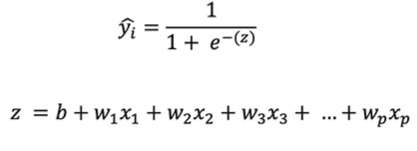

In [ ]:
## Gerçek değerler ile tahmin edilen değerler arasındaki farklara ilişkin log loss değerini minimum yapabilecek ağırlıkları bularak gerçekleştirilir.

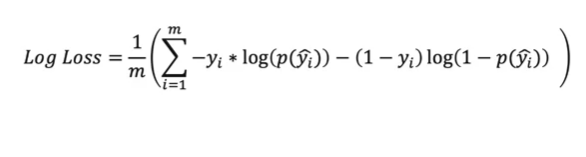

In [ ]:
## Gradient Descent
## Entropi ne kadar yüksek ise çeşitlilik o kadar fazladır. Entropinin düşük çıkmasını bekleriz.

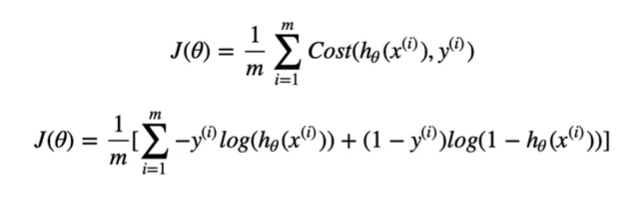

In [ ]:
## Başarı Değerlendirme:

## Confusion Matrix :

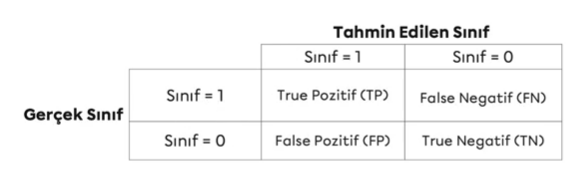

In [ ]:
## Accuracy : Doğru sınıflandırma oranıdır
## (TP + TN) / (TN + TP + FP + FN)

In [ ]:
## Precision : Pozitif sınıf(1) tahminlerinin başarı oranıdır.
## TP / (TP + FP)

In [ ]:
## Recall : Pozitif sınıfın(1) doğru tahmin edilme oranıdır.
## TP / (TP + FN)

In [ ]:
## F1 SCORE : 2 * (Precision * Recall) / (Precision + Recall)

In [ ]:
## gerçekte false olan bir değeri true tahmin etme I. tip hatadır.
## gerçekte true olan bir değeri false tahmin etme II. tip hatadır. bu hataya kritik hata denir maliyet ve risk taşır.

In [ ]:
## eğer veri seti dengeli dağılmış ise accuracy kullanılır.
## ancak veri seti dengeli dağılmamış ise recall ve precision değerleri kullanılır

In [ ]:
## Classification Threshold:
## Eşik değeridir. 1 sınıfına ait olma olasılığının threshold değeridir.

In [ ]:
## Eşik değeri değiştiğinde başarı oranları değişkenlik göstermektedir.Bu nedenle optimum eşik değeri tespit edilmelidir.

In [ ]:
## ROC Eğrisi (ROC Curve)

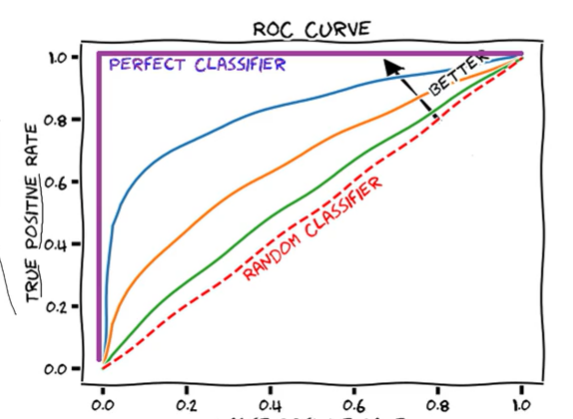

In [ ]:
## Eğriler altında kalan alanın integrali alınırsa Area Under Curve (AUC) metriği elde edilir.
## AUC : eğri altında kalan alandır.
## AUC : tüm olası sınıflandrma eşikleri için toplu bir performans ölçüsüdür.

In [ ]:
## UYGULAMA

## Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadığını tahmin edebilecek bir makine öğrenmesi modeli geliştirme.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_validate

In [8]:
def outlier_threshold (dataframe, col_name, q1=0.05, q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

In [9]:
def check_outlier(dataframe, col_name):
  low_limit , up_limit =  outlier_threshold(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [10]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_threshold(dataframe, col_name)
  dataframe.loc[dataframe[col_name] < low_limit, col_name] = low_limit
  dataframe.loc[dataframe[col_name] > up_limit, col_name] = up_limit

In [11]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width",500)

In [12]:
## Keşifçi Veri Analizinin Gerçekleştirilmesi : EDA

df_ = pd.read_csv("/content/diabetes.csv")
df = df_.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [13]:
## Target Analizi:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

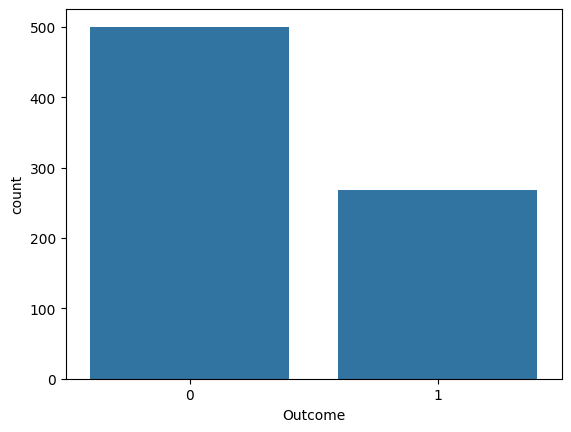

In [14]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [15]:
## bağımlı değişkenin sınıfsal dağılım oranı:

100 * df["Outcome"].value_counts() / len(df)

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

In [16]:
## Feature Analizleri:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [17]:
def grap_col_names(dataframe, cat_th= 10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [18]:
cat_cols, num_cols, cat_but_car = grap_col_names(df)
print(cat_cols)
print(num_cols)
print(cat_but_car)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
['Outcome']
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
[]


In [19]:
## Sayısal değişkenlerin grafik değerlendirmesi:
def plot_numerical_col(dataframe, num_cols):
  dataframe[num_cols].hist(bins=20)
  plt.xlabel(num_cols)
  plt.show(block=True)

Pregnancies


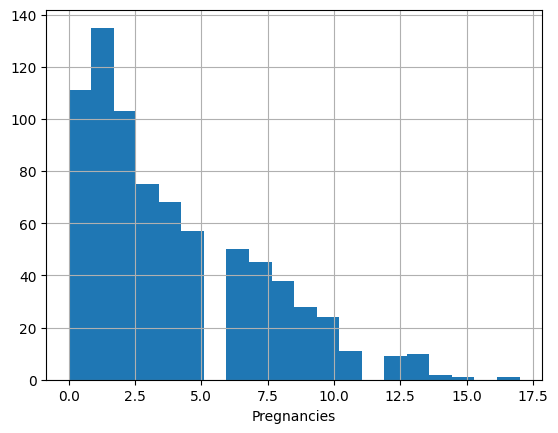

Glucose


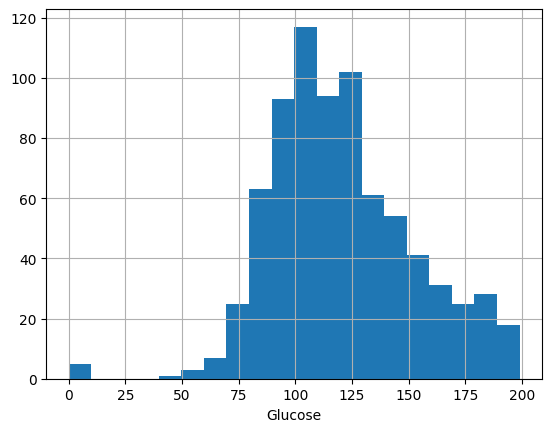

BloodPressure


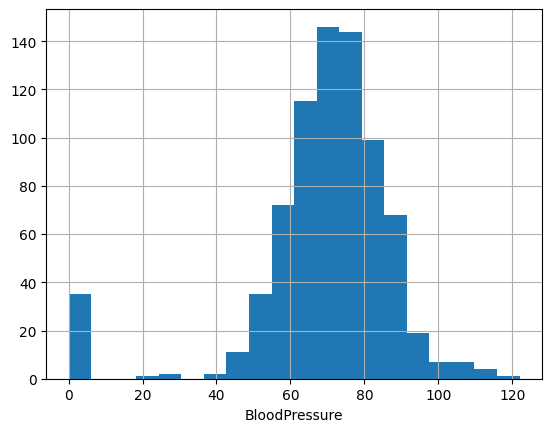

SkinThickness


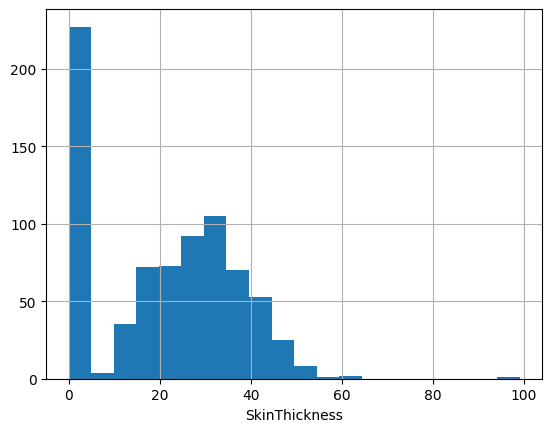

Insulin


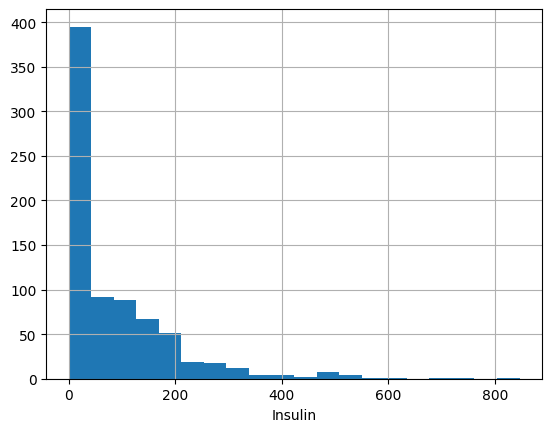

BMI


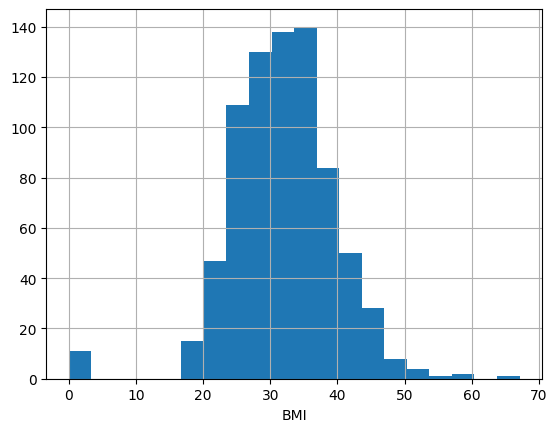

DiabetesPedigreeFunction


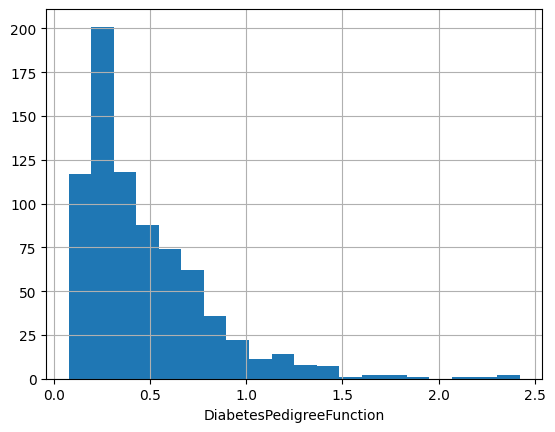

Age


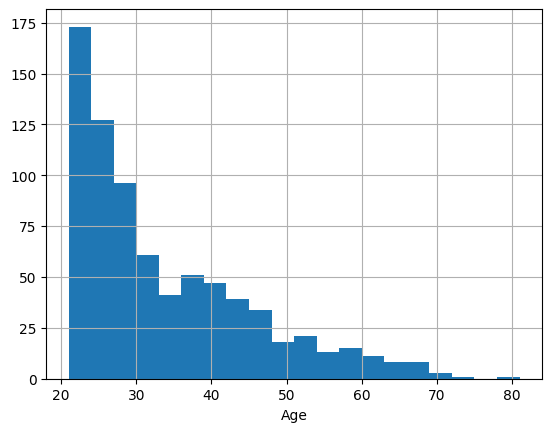

In [20]:
for col in num_cols:
  print(col)
  plot_numerical_col(df, col)

In [21]:
## Target vs Features:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [22]:
for col in num_cols:
  target_summary_with_num(df,"Outcome",col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [23]:
## Data Pre-Processing:

for col in num_cols:
  print(col,check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [24]:
replace_with_thresholds(df, "Insulin")

In [25]:
for col in num_cols:
  print(col,check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [26]:
## Değişkenler standartlaştırılmalıdır.
## Robust scaler aykırı değerlerden etkilenmiyor.

for col in num_cols:
  df[col] = RobustScaler().fit_transform(df[[col]])

In [27]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


In [28]:
## Modelleme:

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X,y)

In [29]:
print(log_model.intercept_)
print(log_model.coef_)

[-1.23367499]
[[ 0.60026858  1.41864488 -0.2317767   0.02249032 -0.14660392  0.81662929
   0.35519151  0.25514769]]


In [ ]:
## Model denklemi : (log_model.intercept_) + log_model.coef_[0][0] * x1 + log_model.coef_[0][1] * x2 .....

In [30]:
## Tahminleme işleminin yapılması:

y_pred = log_model.predict(X)
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [31]:
## Model Başarı Değerlendirme:

def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y,y_pred),2)
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm, annot=True, fmt=".0f")
  plt.xlabel("y_pred")
  plt.ylabel("y")
  plt.title("Accuracy Score: {0}".format(acc),size=10)
  plt.show()


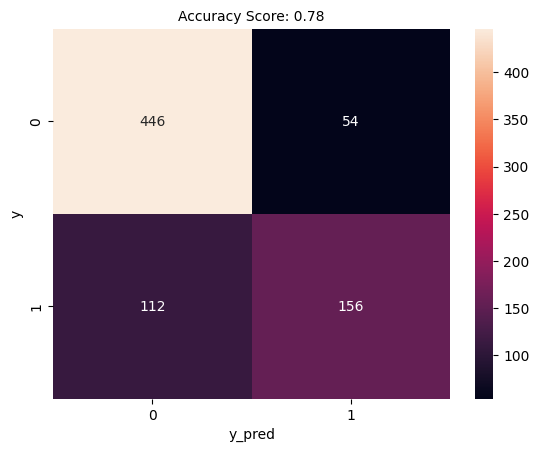

In [32]:
plot_confusion_matrix(y, y_pred)

In [33]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [ ]:
## 1 sınıfına göre başarı değerlendirmesi yapılır.
## accuracy    0.78
## precision   0.74
## recall      0.58
## f1-score    0.65

In [34]:
## ROC AUC: farklı threshold değerlerine göre oluşabilecek başarı değerlendirme metriği

fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.737044776119403


In [35]:
## Model Doğrulama Yöntemi:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20,
                                                    random_state=17)


In [36]:
log_model = LogisticRegression().fit(X_train, y_train)

In [37]:
y_pred = log_model.predict(X_test)
y_pred[0:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1])

In [38]:
y_prob = log_model.predict_proba(X_test)[:,1]

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



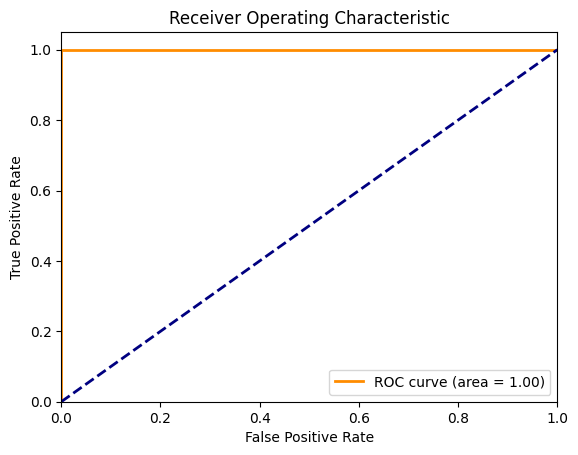

In [45]:
fpr, tpr, thresholds = roc_curve(y_pred, y_prob)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [46]:
## 10 Katlı Çapraz Doğrulama (10Fold Cross Validation)

## model farklı parçalar ile test edilip farklı parçalar ile modellenir.

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X,y)

In [47]:
cv_results = cross_validate(log_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy","precision","recall","f1","roc_auc"])

In [49]:
## test edilen 5 parçanın ortalama acc değeri
cv_results["test_accuracy"].mean()

0.7721925133689839

In [50]:
cv_results["test_precision"].mean()

0.7192472060223519

In [51]:
cv_results["test_recall"].mean()

0.5747030048916841

In [52]:
cv_results["test_f1"].mean()

0.6371421090986309

In [53]:
cv_results["test_roc_auc"].mean()

0.832879105520615

In [55]:
## Prediction for A new Observation
X.columns

random_user = X.sample(1, random_state=45)
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
195,0.400,0.994,0.667,0.562,1.411,0.796,0.059,0.000


In [56]:
log_model.predict(random_user)

array([1])